# Estacionalidad, estacionariedad y normalización en Series Temporales

### Notebook por **David Andrés** 🤖📈🐍 

#### para [💊Machine Learning Pills💊](https://mlpills.dev/)

**Sígueme en Twitter**: [@daansan_ml](https://twitter.com/daansan_ml)




---------------

Vamos a instalar las librerias que vamos a necesitar.

In [1]:
import numpy as np
import pandas as pd 

import datetime

import matplotlib.pyplot as plt

## Importa el dataset

Primero tenemos que importar el dataset.

En este notebook vamos a trabajar con datos sobre la producción de cerveza mensual en Australia.

In [2]:
!wget -P ./dataset --no-check-certificate --content-disposition https://raw.githubusercontent.com/MLPills-Es/Valores-Faltantes-Y-Reduccion-De-Tendencia/main/dataset/monthly-beer-production-in-austr.csv

--2023-02-22 14:51:05--  https://raw.githubusercontent.com/MLPills-Es/Valores-Faltantes-Y-Reduccion-De-Tendencia/main/dataset/monthly-beer-production-in-austr.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 6426 (6.3K) [text/plain]
Saving to: ‘./dataset/monthly-beer-production-in-austr.csv’

monthly-beer-produc 100%[===================>]   6.28K  --.-KB/s    in 0s      

2023-02-22 14:51:06 (50.0 MB/s) - ‘./dataset/monthly-beer-production-in-austr.csv’ saved [6426/6426]



In [22]:
df = pd.read_csv("dataset/monthly-beer-production-in-austr.csv")

### Análisis de Datos Exploratorio

Vamos a ver cómo es el dataset.

In [23]:
df.head()

,Month,Monthly beer production
0,1956-01,93.2
1,1956-02,96.0
2,1956-03,95.2
3,1956-04,77.1
4,1956-05,70.9


Voy a traducir al espanol los nombres de las columnas

In [24]:
df.columns = ['Mes', 'Produccion mensual de cerveza']

En Series Temporales necesitamos que el índice del dataset sea la fecha.

Primero, vamos a comprobar que la fecha tiene el formato correcto (Datetime).

In [25]:
df.dtypes

Mes                               object
Produccion mensual de cerveza    float64
dtype: object

La columna `Mes` no es del tipo Datetime. Vamos a convertirla.

In [26]:
df['Mes'] = pd.to_datetime(df['Mes'], format='%Y-%m')

Ahora podemos verificar que los cambios son correctos.

In [27]:
df.dtypes

Mes                              datetime64[ns]
Produccion mensual de cerveza           float64
dtype: object

Vamos a poner la fecha (`Mes`) en el índice.

In [28]:
df = df.set_index('Mes')

Y finalmente volver a verificar que ha funcionado. 

In [29]:
df.head()

,Produccion mensual de cerveza
Mes,
1956-01-01,93.2
1956-02-01,96.0
1956-03-01,95.2
1956-04-01,77.1
1956-05-01,70.9


Lo tenemos como queríamos, el índice del dataframe es la fecha.

Vamos a convertir también el dataframe a series seleccionando solo la única columna presente. Podemos hacer esto aquí porque estamos en un caso univariable.

In [30]:
df_cerveza = df['Produccion mensual de cerveza']

Es muy importante visualizar los datos. 

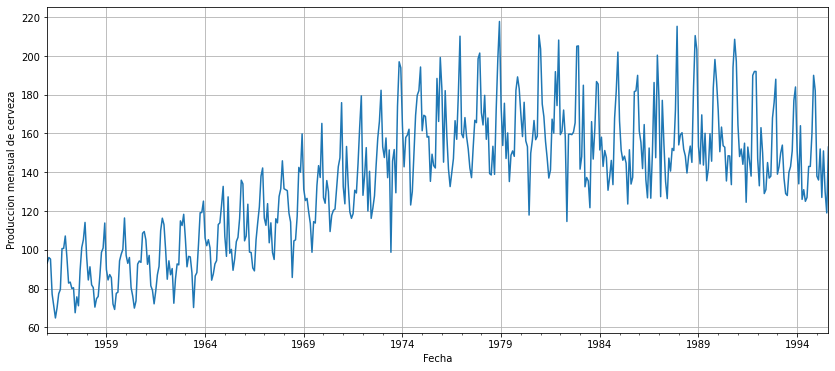

In [31]:
# Importar librerias requeridas
import matplotlib.pyplot as plt

# Visualizar datos
df_cerveza.plot(figsize=(14,6))
plt.xlabel('Fecha')
plt.ylabel('Produccion mensual de cerveza')
plt.grid()
plt.show()

Algunas observaciones:
* No es estacionario
* Parece haber un componente estacional
* Hay tendencia y varianza incremental
* Parece haber valores atípicos

### Valores faltantes

Tenemos que comprobar que no haya valores faltantes en el dataframe.

In [32]:
df_cerveza.isna().sum()

0

Afortunadamente no hay. 

### Deducción de tendencia

El primer paso es quitar la tendencia. Hay muchas formas de conseguirlo, nosotros usaremos *diferenciación*.

In [33]:
df_cerveza = df_cerveza.diff()

Tenemos que quitar el primer valor *NaN* que viene de diferenciar.

In [34]:
df_cerveza = df_cerveza.dropna()

Ahora podemos ver su aspecto. 

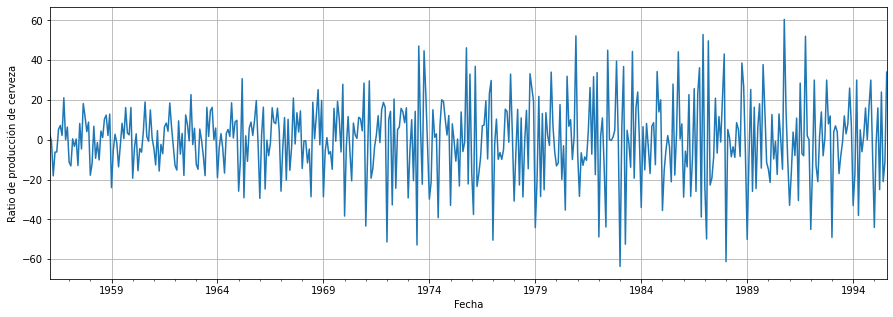

In [35]:
df_cerveza.plot(figsize=(15,5))
plt.xlabel('Fecha')
plt.ylabel('Ratio de producción de cerveza')
plt.grid()
plt.show()

Puedes ver que está centrado alrededor de cero.

Sin embargo, todavía tenemos volatilidad incremental que tenemos que tratar para conseguir que sea estacionario.

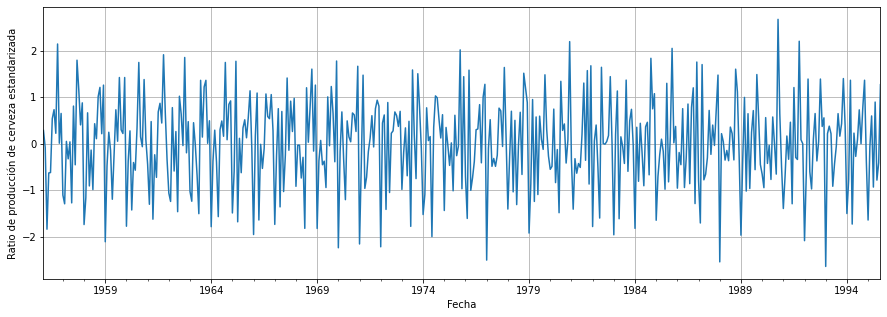

In [36]:
# Calcula la variancia anual (equivalente a desviación típica)
varianza_anual = df_cerveza.groupby(df_cerveza.index.year).std()
mapped_varianza_anual = df_cerveza.index.map(
    lambda x: varianza_anual.loc[x.year])

# Estandarizar la varianza anual
df_cerveza = df_cerveza / mapped_varianza_anual

# Mostrar resultado
df_cerveza.plot(figsize=(15,5))
plt.xlabel('Fecha')
plt.ylabel('Ratio de producción de cerveza estandarizada')
plt.grid()
plt.show()

Finalmente podemos ver como nuestros datos parecen tener varianza y media constante. Estamos más cerca de conseguir que sea estacionario.

### Quitar estacionalidad

Antes de comenzar, podríamos usar la biblioteca statsmodels de Python para ver la descomposición estacional de los datos antes de eliminar la tendencia. Este no es un paso obligatorio, pero podría ser útil para visualizar los componentes de los datos de la serie temporal. Antes de usarlo, debemos seleccionar el período de estacionalidad. Asumimos que hay estacionalidad anual, así que estableceremos el periodo como 12 (12 meses en un año).

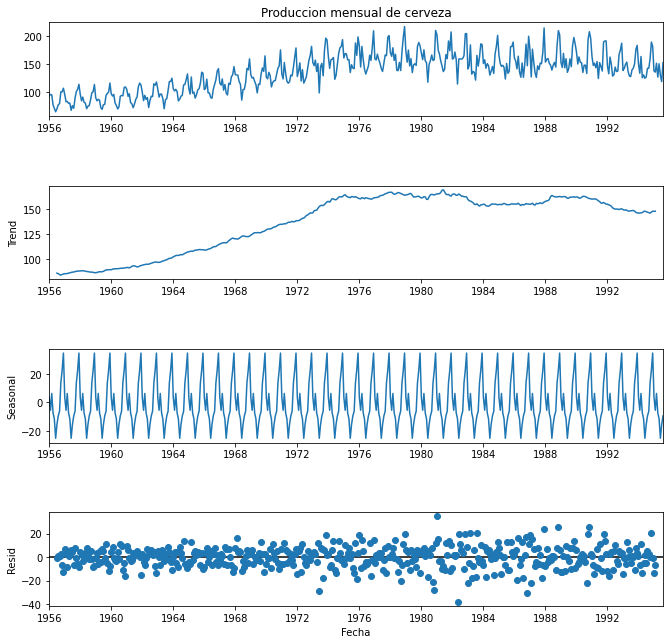

In [39]:
# Importar libraría
import statsmodels.api as sm

# Descomponer datos seleccionando la frecuencia adecuada
decomp = sm.tsa.seasonal_decompose(
  df['Produccion mensual de cerveza'], period=12)
decomp_plot = decomp.plot()

# Mostrar resultado
plt.xlabel('Fecha')
decomp_plot.set_figheight(10)
decomp_plot.set_figwidth(10)
plt.show()

Como era de esperar, podemos ver un pico de producción cada año y una tendencia suave sin altibajos, solo la tendencia real a lo largo de los años. También podemos ver los residuales, que hacen referencia a todo el ruido o anomalías durante este periodo de tiempo después de extraer el componente estacional y la tendencia.

Ahora veremos una forma más intuitiva de quitar la estacionalidad.

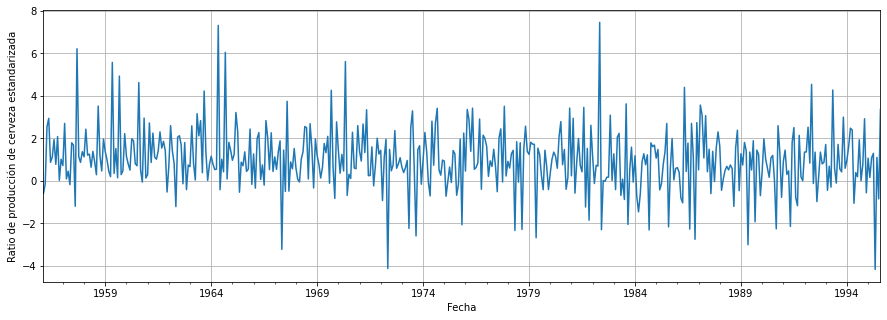

In [41]:
# Calcula la media anual
media_anual = df_cerveza.groupby(df_cerveza.index.month).mean()
mapped_media_anual = df_cerveza.index.map(
    lambda x: media_anual.loc[x.month])

# Estandarizar la media mensual
df_cerveza = df_cerveza / mapped_media_anual

# Plot outcome
df_cerveza.plot(figsize=(15,5))
plt.xlabel('Fecha')
plt.ylabel('Ratio de producción de cerveza estandarizada')
plt.grid()
plt.show()

Podemos ver ahora que el resultado parece bastante aleatorio y, por lo tanto, estacionario. Podríamos comprobar si este es realmente el caso.

### Check for stationarity

La estacionariedad se refiere a una propiedad de los datos donde las propiedades estadísticas como la media, la varianza y la estructura de autocorrelación permanecen constantes a lo largo del tiempo.

Podemos usar el test Augmented Dickey-Fuller (ADF) y el test Kwiatkowski-Phillips-Schmidt-Shin (KPSS) para comprobar si nuestros datos son estacionarios:

In [42]:
# Importa las librerías requeridas
from statsmodels.tsa.stattools import adfuller, kpss

# Efectuar un test ADF
resultado = adfuller(df_cerveza)
print('Test ADF:\tp-value: {:.3f}'.format(resultado[1]))

# Efectuar un test KPSS
resultado = kpss(df_cerveza)
print('Test KPSS:\tp-value: {:.3f}'.format(resultado[1]))

Test ADF:	p-value: 0.001
Test KPSS:	p-value: 0.010


/usr/local/lib/python3.8/dist-packages/statsmodels/tsa/stattools.py:1875: FutureWarning: The behavior of using nlags=None will change in release 0.13.Currently nlags=None is the same as nlags="legacy", and so a sample-size lag length is used. After the next release, the default will change to be the same as nlags="auto" which uses an automatic lag length selection method. To silence this warning, either use "auto" or "legacy"
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.8/dist-packages/statsmodels/tsa/stattools.py:1906: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  warnings.warn(


Para el test ADF, debemos verificar si el p-value es más bajo que el nivel de significancia (a menudo establecido como 0.05). En este caso, lo es, por lo que los datos son estacionarios según este criterio.
Para el test KPSS, debemos verificar si el p-value es mayor que el nivel de significación. En este caso es inferior a 0.05, por lo que no es estacionario según este test.

Todavía tenemos que trabajar para hacer que nuestros datos sean estacionarios. Simplemente podemos aplicar otra diferenciación y realizar ambos tests de nuevo.

In [44]:
# Diferenciar nuestros datos una vez más
df_cerveza = df_cerveza.diff()[1:]

# Efectuar un test ADF
resultado = adfuller(df_cerveza)
print('Test ADF:\tp-value: {:.3f}'.format(resultado[1]))

# Efectuar un test KPSS
resultado = kpss(df_cerveza)
print('Test KPSS:\tp-value: {:.3f}'.format(resultado[1]))

Test ADF:	p-value: 0.000
Test KPSS:	p-value: 0.100


/usr/local/lib/python3.8/dist-packages/statsmodels/tsa/stattools.py:1875: FutureWarning: The behavior of using nlags=None will change in release 0.13.Currently nlags=None is the same as nlags="legacy", and so a sample-size lag length is used. After the next release, the default will change to be the same as nlags="auto" which uses an automatic lag length selection method. To silence this warning, either use "auto" or "legacy"
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.8/dist-packages/statsmodels/tsa/stattools.py:1910: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warnings.warn(


Ahora, el p-value del test ADF sigue siendo inferior a 0.05 y el p-value del test KPSS es superior a 0.05. Por lo tanto, tenemos datos estacionarios.

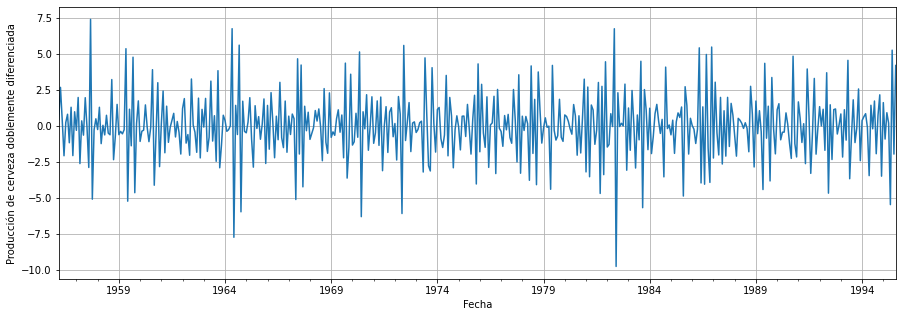

In [45]:
df_cerveza.plot(figsize=(15,5))
plt.xlabel('Fecha')
plt.ylabel('Producción de cerveza doblemente diferenciada')
plt.grid()
plt.show()

### Normalizar los datos

El siguiente paso es llevar los datos a una misma escala, a esto se llama normalización.

Usaremos el Standard Scaler, ya que será útil más adelante para eliminar los valores atípicos. Hay dos alternativas aquí: el enfoque intuitivo y usar la biblioteca scikit-learn.

El enfoque intuitivo es muy fácil y sencillo de implementar:

In [46]:
# Calcular la media y la desviación típica
media = df_cerveza.mean()
desviacion = df_cerveza.std()

# Normalizar datos
df_cerveza = (df_cerveza - media) / desviacion

Podemos lograr el mismo resultado con la función de scikit-learn:

In [47]:
# Importar librería
from sklearn.preprocessing import StandardScaler

# Crear un objeto StandardScaler
escalador = StandardScaler()

# Convertir datos a numpy array y cambiar tamaño
array_cerveza = df_cerveza.values.reshape(-1, 1)

# Ajustar escalador a los datos y transformarlos
datos_escalados = escalador.fit_transform(array_cerveza)

# Reconvertir a pandas Series
df_cerveza = pd.Series(datos_escalados.flatten(), 
                    index=df_cerveza.index, name='Mes')

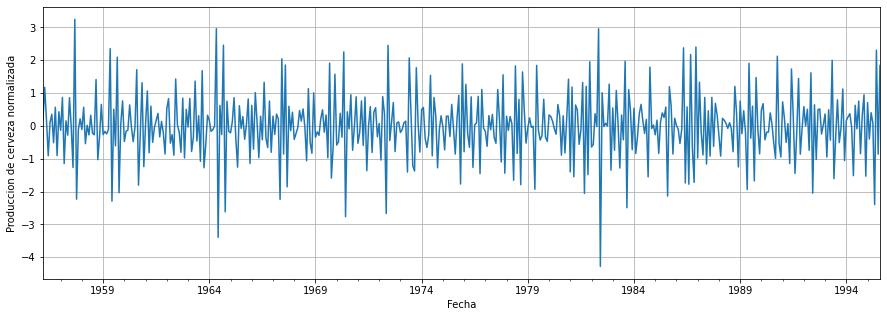

In [48]:
df_cerveza.plot(figsize=(15,5))
plt.xlabel('Fecha')
plt.ylabel('Produccion de cerveza normalizada')
plt.grid()
plt.show()

Finalmente podemos decir que nuestros datos son estacionarios y normalizados. ¡Ahora estamos un paso más cerca de poder comenzar a construir nuestro modelo!

------

#### [💊Machine Learning Pills💊](https://mlpills.dev/)

**Sígueme en Twitter**: [@daansan_ml](https://twitter.com/daansan_ml)

### **David Andrés** 🤖📈🐍 